# Problem: Predicting Airplane Delays

The goals of this notebook are:
- Process and create a dataset from downloaded ZIP files
- Exploratory data analysis (EDA)
- Establish a baseline model and improve it

## Introduction to business scenario
You work for a travel booking website that is working to improve the customer experience for flights that were delayed. The company wants to create a feature to let customers know if the flight will be delayed due to weather when the customers are booking the flight to or from the busiest airports for domestic travel in the US. 

You are tasked with solving part of this problem by leveraging machine learning to identify whether the flight will be delayed due to weather. You have been given access to the a dataset of on-time performance of domestic flights operated by large air carriers. You can use this data to train a machine learning model to predict if the flight is going to be delayed for the busiest airports.

### Dataset
The provided dataset contains scheduled and actual departure and arrival times reported by certified US air carriers that account for at least 1 percent of domestic scheduled passenger revenues. The data was collected by the Office of Airline Information, Bureau of Transportation Statistics (BTS). The dataset contains date, time, origin, destination, airline, distance, and delay status of flights for flights between 2014 and 2018.
The data are in 60 compressed files, where each file contains a CSV for the flight details in a month for the five years (from 2014 - 2018). The data can be downloaded from this link: [https://ucstaff-my.sharepoint.com/:f:/g/personal/ibrahim_radwan_canberra_edu_au/Er0nVreXmihEmtMz5qC5kVIB81-ugSusExPYdcyQTglfLg?e=bNO312]. Please download the data files and place them on a relative path. Dataset(s) used in this assignment were compiled by the Office of Airline Information, Bureau of Transportation Statistics (BTS), Airline On-Time Performance Data, available with the following link: [https://www.transtats.bts.gov/Fields.asp?gnoyr_VQ=FGJ]. 

# Step 1: Prepare the environment 

Use one of the labs which we have practised on with the Amazon Sagemakers where you perform the following steps:
1. Start a lab.
2. Create a notebook instance and name it "oncloudproject".
3. Increase the used memory to 25 GB from the additional configurations.
4. Open Jupyter Lab and upload this notebook into it.
5. Upload the two combined CVS files (combined_csv_v1.csv and combined_csv_v2.csv), which you created in Part A of this project.

# Step 2: Build and evaluate simple models

Write code to perform the follwoing steps:
1. Split data into training, validation and testing sets (70% - 15% - 15%).
2. Use linear learner estimator to build a classifcation model.
3. Host the model on another instance
4. Perform batch transform to evaluate the model on testing data
5. Report the performance metrics that you see better test the model performance 

Note: You are required to perform the above steps on the two combined datasets separatey and to comments on the difference.

In [1]:
! pip install --upgrade sagemaker

In [2]:
import os
import io
import pandas as pd
import numpy as np
import boto3
import sagemaker
from sagemaker.serializers import CSVSerializer
from sagemaker.amazon.amazon_estimator import RecordSet
from sagemaker.image_uris import retrieve
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [3]:
role = sagemaker.get_execution_role()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [4]:
# Upload csv file to s3 and load data from the S3
bucket= 'project-data-science-1'
data1 = 'data/combined_csv_v1.csv'
data2 = 'data/combined_csv_v2.csv'

# Load data
data_v1 = pd.read_csv('s3://{}/{}'.format(bucket, data1))
data_v2 = pd.read_csv('s3://{}/{}'.format(bucket, data2))

In [5]:
data_v1.head()

target  Distance  Quarter_2  Quarter_3  Quarter_4  Month_2  Month_3  \
0     0.0    1464.0          0          0          1        0        0   
1     1.0    1464.0          0          0          1        0        0   
2     0.0    1464.0          0          0          1        0        0   
3     0.0    1464.0          0          0          1        0        0   
4     0.0    1464.0          0          0          1        0        0   

   Month_4  Month_5  Month_6  ...  DepHourofDay_14  DepHourofDay_15  \
0        0        0        0  ...                0                0   
1        0        0        0  ...                0                0   
2        0        0        0  ...                0                0   
3        0        0        0  ...                0                0   
4        0        0        0  ...                0                0   

   DepHourofDay_16  DepHourofDay_17  DepHourofDay_18  DepHourofDay_19  \
0                0                0                0                0   
1                0                0                0                0   
2                0                0                0                0   
3                0                0                0                0   
4                0                0                0                0   

   DepHourofDay_20  DepHourofDay_21  DepHourofDay_22  DepHourofDay_23  
0                0                0                0                0  
1                0                0                0                0  
2                0                0                0                0  
3                0                0                0                0  
4                0                0                0                0  

[5 rows x 94 columns]

In [6]:
data_v1.shape

(1635590, 94)

In [7]:
data_v2.head()

target  Distance  DepHourofDay  AWND_O  PRCP_O  TAVG_O  AWND_D  PRCP_D  \
0     0.0    1464.0             7      57       0   281.0      25       0   
1     1.0    1464.0             7      72      81   284.0      11       0   
2     0.0    1464.0             7      49       0   219.0      24       0   
3     0.0    1464.0             7      29       0   182.0      30       0   
4     0.0    1464.0             7      52       0   214.0      41       0   

   TAVG_D  SNOW_O  ...  Origin_SFO  Dest_CLT  Dest_DEN  Dest_DFW  Dest_IAH  \
0   209.0     0.0  ...           0         0         0         0         0   
1   226.0     0.0  ...           0         0         0         0         0   
2   244.0     0.0  ...           0         0         0         0         0   
3   247.0     0.0  ...           0         0         0         0         0   
4   220.0     0.0  ...           0         0         0         0         0   

   Dest_LAX  Dest_ORD  Dest_PHX  Dest_SFO  is_holiday_1  
0         0         0         0         1             0  
1         0         0         0         1             0  
2         0         0         0         1             0  
3         0         0         0         1             0  
4         0         0         0         1             0  

[5 rows x 86 columns]

In [8]:
data_v2.shape

(1635590, 86)

In [9]:
# Split data into training, validation and testing sets (70% - 15% - 15%).
def split_data(data):
    train, test_and_validate = train_test_split(data, test_size=0.3, random_state=42, stratify=data['target'])
    test, validate = train_test_split(test_and_validate, test_size=0.5, random_state=42, stratify=test_and_validate['target'])
    return train, validate, test

# Linear Learner model

In [10]:
# Split dataset
train_v1, val_v1, test_v1 = split_data(data_v1)
train_v2, val_v2, test_v2 = split_data(data_v2)

### Linear Learner model for data_v1

In [11]:
##Create Linear Learner Estimator
classifier_estimator = sagemaker.LinearLearner(role=role,
                                               instance_count=1,
                                               instance_type='ml.m4.4xlarge',
                                               predictor_type='binary_classifier',
                                               binary_classifier_model_selection_criteria = 'cross_entropy_loss')

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [12]:
# Create input data
def create_input_data(train, validate, test, classifier_estimator):
    train_input = classifier_estimator.record_set(train.values[:, 1:].astype(np.float32), train.values[:, 0].astype(np.float32), channel='train')
    val_input = classifier_estimator.record_set(validate.values[:, 1:].astype(np.float32), validate.values[:, 0].astype(np.float32), channel='validation')
    test_input = classifier_estimator.record_set(test.values[:, 1:].astype(np.float32), test.values[:, 0].astype(np.float32), channel='test')

    return train_input, val_input, test_input

In [13]:
### Fit the classifier for data_v1
train_input_v1, val_input_v1, test_input_v1 = create_input_data(train_v1, val_v1, test_v1, classifier_estimator)
classifier_estimator.fit([train_input_v1, val_input_v1, test_input_v1])

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: linear-learner-2023-11-02-15-13-39-498


2023-11-02 15:13:39 Starting - Starting the training job...
2023-11-02 15:13:53 Starting - Preparing the instances for training.........
2023-11-02 15:15:21 Downloading - Downloading input data...
2023-11-02 15:15:56 Training - Downloading the training image......
2023-11-02 15:16:47 Training - Training image download completed. Training in progress...Docker entrypoint called with argument(s): train
Running default environment configuration script
[11/02/2023 15:17:15 INFO 140656009815872] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'loss

## Evaluation for data_v1

In [14]:
### Metrics for the training job
sagemaker.analytics.TrainingJobAnalytics(classifier_estimator._current_job_name, 
                                         metric_names = ['test:objective_loss', 
                                                         'test:binary_f_beta',
                                                         'test:precision',
                                                         'test:recall']
                                        ).dataframe()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


timestamp          metric_name     value
0        0.0  test:objective_loss  0.491824
1        0.0   test:binary_f_beta  0.009858
2        0.0       test:precision  0.585812
3        0.0          test:recall  0.004971

In [15]:
# Set path for model
prefix='linear-leaner-v1'
train_file='train.csv'
test_file='test.csv'
validate_file='validate.csv'
whole_file='data_v1.csv'
s3_resource = boto3.Session().resource('s3')

def upload_s3_csv(filename, folder, dataframe):
    csv_buffer = io.StringIO()
    dataframe.to_csv(csv_buffer, header=False, index=False )
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(Body=csv_buffer.getvalue())

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


In [16]:
def batch_linear_predict(test_data, estimator):
    batch_X = test_data.iloc[:,1:]
    batch_X_file='batch-in.csv'
    upload_s3_csv(batch_X_file, 'batch-in', batch_X)

    batch_output = "s3://{}/{}/batch-out/".format(bucket,prefix)
    batch_input = "s3://{}/{}/batch-in/{}".format(bucket,prefix,batch_X_file)

    classifier_transformer = estimator.transformer(instance_count=1,
                                           instance_type='ml.m4.xlarge',
                                           strategy='MultiRecord',
                                           assemble_with='Line',
                                           output_path=batch_output)

    classifier_transformer.transform(data=batch_input,
                             data_type='S3Prefix',
                             content_type='text/csv',
                             split_type='Line')
    
    classifier_transformer.wait()

    s3 = boto3.client('s3')
    obj = s3.get_object(Bucket=bucket, Key="{}/batch-out/{}".format(prefix,'batch-in.csv.out'))
    target_predicted_df = pd.read_json(io.BytesIO(obj['Body'].read()),orient="records",lines=True)
    return test_data.iloc[:,0], target_predicted_df.iloc[:,0]

In [17]:
test_labels, target_predicted = batch_linear_predict(test_v1, classifier_estimator)

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating model with name: linear-learner-2023-11-02-15-21-32-642
INFO:sagemaker:Creating transform job with name: linear-learner-2023-11-02-15-21-33-328


...........................................Docker entrypoint called with argument(s): serve
Running default environment configuration script
[11/02/2023 15:28:39 INFO 140318087190336] Memory profiler is not enabled by the environment variable ENABLE_PROFILER.
Docker entrypoint called with argument(s): serve
Running default environment configuration script
[11/02/2023 15:28:39 INFO 140318087190336] Memory profiler is not enabled by the environment variable ENABLE_PROFILER.
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:495: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if cons['type'] is 'ineq':
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:743: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(self.X_min) is not 0:
/opt/amazon/lib/python3.8/site-packages/mxnet/mod

In [18]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(test_labels, target_predicted):
    # Compute the Confusion Matrix
    conf_matrix = confusion_matrix(test_labels, target_predicted)
    
    
    # Extracting values from the confusion matrix
    TN, FP, FN, TP = confusion_matrix(test_labels, target_predicted).ravel()

    # Calculating statistics
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    sensitivity = recall
    specificity = TN / (TN + FP)
    
    # Printing statistics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall(Sensitivity): {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")
    
    # visualize confusion matrix with seaborn heatmap
    cm_matrix = pd.DataFrame(data=conf_matrix, columns=['Predicted 1', 'Predicted 0'], 
                         index=['Actual 1', 'Actual 0'])
    sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    plt.show()
    

In [19]:
def plot_roc(test_labels, target_predicted):
    fpr, tpr, thresholds = roc_curve(test_labels, target_predicted)
    roc_auc = roc_auc_score(test_labels, target_predicted)
    print(f"Validation AUC: {roc_auc:.4f}")
    
    plt.figure(figsize=(10,8))
    plt.plot(fpr, tpr, color='orange', label=f'ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

Accuracy: 0.7904
Precision: 0.5858
Recall(Sensitivity): 0.0050
Specificity: 0.9991


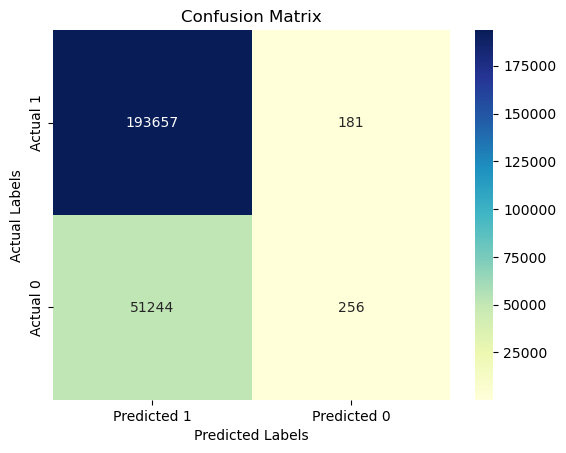

In [20]:
plot_confusion_matrix(test_labels, target_predicted)

Validation AUC: 0.5020


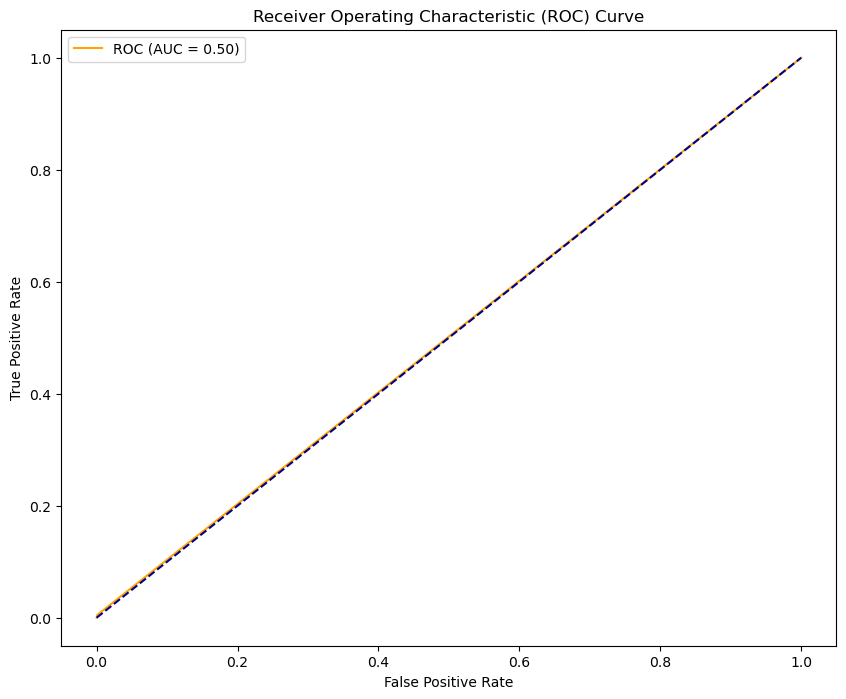

In [21]:
plot_roc(test_labels, target_predicted)

### Linear Learner model for data_v2

In [22]:
# Instantiate the LinearLearner estimator object
classifier_estimator2 = sagemaker.LinearLearner(role=role,
                                               instance_count=1,
                                               instance_type='ml.m4.4xlarge',
                                               predictor_type='binary_classifier',
                                               binary_classifier_model_selection_criteria = 'cross_entropy_loss')

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [23]:
### Fit the classifier for data_v2
train_input_v2, val_input_v2, test_input_v2 = create_input_data(train_v2, val_v2, test_v2, classifier_estimator2)
classifier_estimator2.fit([train_input_v2, val_input_v2, test_input_v2])

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: linear-learner-2023-11-02-15-30-50-893


2023-11-02 15:30:51 Starting - Starting the training job...
2023-11-02 15:31:17 Starting - Preparing the instances for training.........
2023-11-02 15:32:33 Downloading - Downloading input data...
2023-11-02 15:33:13 Training - Downloading the training image......
2023-11-02 15:33:59 Training - Training image download completed. Training in progress...Docker entrypoint called with argument(s): train
Running default environment configuration script
[11/02/2023 15:34:27 INFO 140013592176448] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'loss

## Evaluation for data_v2

In [24]:
### Metrics for the training job
sagemaker.analytics.TrainingJobAnalytics(classifier_estimator._current_job_name, 
                                         metric_names = ['test:objective_loss', 
                                                         'test:binary_f_beta',
                                                         'test:precision',
                                                         'test:recall']
                                        ).dataframe()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


timestamp          metric_name     value
0        0.0  test:objective_loss  0.491824
1        0.0   test:binary_f_beta  0.009858
2        0.0       test:precision  0.585812
3        0.0          test:recall  0.004971

In [25]:
# Set second path for model
prefix='linear-leaner-v2'

In [26]:
test_labels, target_predicted = batch_linear_predict(test_v2, classifier_estimator2)

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating model with name: linear-learner-2023-11-02-15-38-43-128
INFO:sagemaker:Creating transform job with name: linear-learner-2023-11-02-15-38-43-818


............................................Docker entrypoint called with argument(s): serve
Running default environment configuration script
[11/02/2023 15:46:05 INFO 140182816995136] Memory profiler is not enabled by the environment variable ENABLE_PROFILER.
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:495: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if cons['type'] is 'ineq':
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:743: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(self.X_min) is not 0:
[11/02/2023 15:46:09 WARNING 140182816995136] Loggers have already been setup.
[11/02/2023 15:46:09 INFO 140182816995136] loaded entry point class algorithm.serve.server_config:config_api
[11/02/2023 15:46:09 INFO 140182816995136] loading entry points
[11/02/2023 1

Accuracy: 0.7929
Precision: 0.5636
Recall(Sensitivity): 0.0590
Specificity: 0.9879


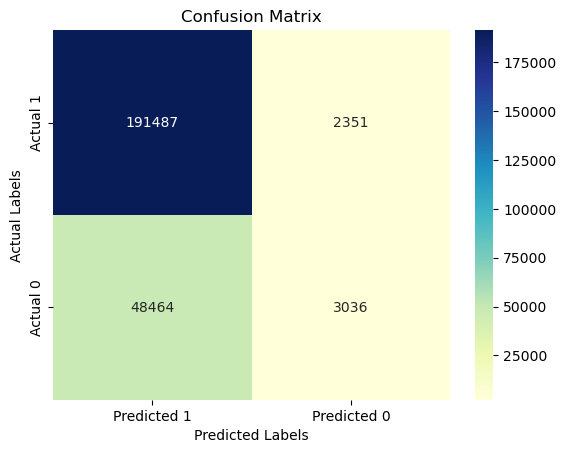

In [27]:
plot_confusion_matrix(test_labels, target_predicted)

Validation AUC: 0.5234


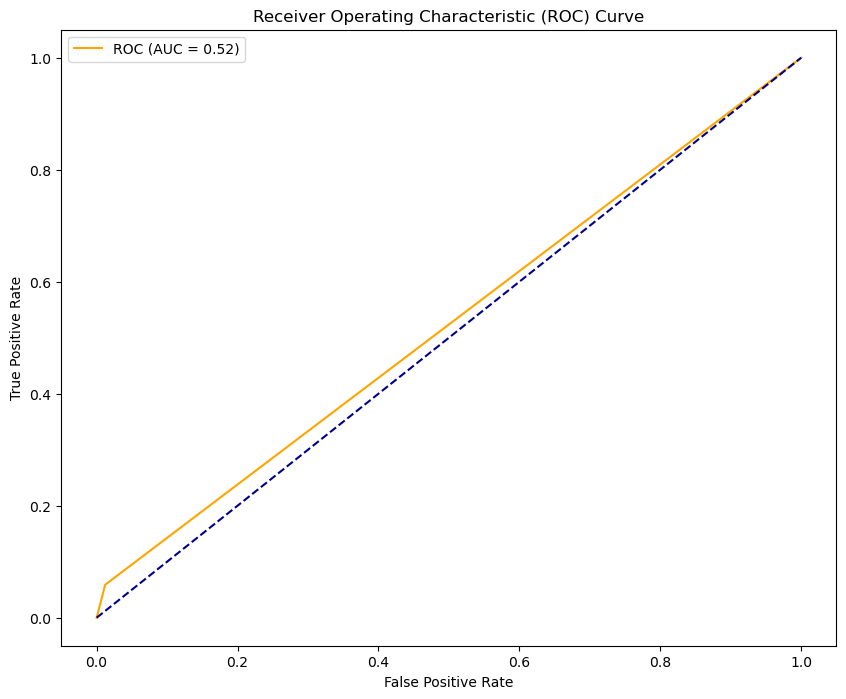

In [28]:
plot_roc(test_labels, target_predicted)

# Step 3: Build and evaluate ensembe models

Write code to perform the follwoing steps:
1. Split data into training, validation and testing sets (70% - 15% - 15%).
2. Use xgboost estimator to build a classifcation model.
3. Host the model on another instance
4. Perform batch transform to evaluate the model on testing data
5. Report the performance metrics that you see better test the model performance 
6. write down your observation on the difference between the performance of using the simple and ensemble models.
Note: You are required to perform the above steps on the two combined datasets separatey.

<font color='blue'>
5. Metrics provided include Accuracy, Precision, Recall, Specificity, and Validation AUC. The AUC, which measures the model's ability to distinguish between classes, appears crucial given the close-to-random values seen for the Linear model.
</font>

<font color='blue'>
6. Model Performance Observation:
XGBoost, an ensemble model, outperforms the Linear Learner across both datasets. The higher recall, precision, and AUC scores in XGBoost, especially on data_v2, suggest it's more adept at handling this problem than the simpler Linear model.</font>

# XGBoost Model

In [29]:
# Upload data to S3
def upload_to_s3(prefix, train, validate, test):
    upload_s3_csv(train_file, 'train', train)
    upload_s3_csv(validate_file, 'validate', validate)
    upload_s3_csv(test_file, 'test', test)

In [30]:
# Train XGBoost model on SageMaker
def train_xgb(prefix, train, validate):
    # Train an XGBoost model using SageMaker with specified S3 prefix and data.
    # Set up the S3 input channels for training and validation
    train_channel = sagemaker.inputs.TrainingInput(
        f"s3://{bucket}/{prefix}/train/{train_file}", content_type='text/csv')
    validate_channel = sagemaker.inputs.TrainingInput(
        f"s3://{bucket}/{prefix}/validate/{validate_file}", content_type='text/csv')
    
    data_channels = {'train': train_channel, 'validation': validate_channel}
    
    # Retrieve the XGBoost container
    container = retrieve('xgboost', boto3.Session().region_name, '1.0-1')
    
    # Set up the SageMaker session
    sess = sagemaker.Session()
    s3_output_location = f"s3://{bucket}/{prefix}/output/"

    # Initialize the XGBoost estimator
    xgb = sagemaker.estimator.Estimator(container,
                                        role=sagemaker.get_execution_role(),
                                        instance_count=1,
                                        instance_type='ml.m4.4xlarge',
                                        output_path=s3_output_location,
                                        sagemaker_session=sess)
    
    # Set hyperparameters for the model
    xgb.set_hyperparameters(max_depth=5,
                            eta=0.2,
                            gamma=4,
                            min_child_weight=6,
                            subsample=0.8,
                            silent=0,
                            objective='binary:logistic',
                            eval_metric="auc",
                            num_round=100)
    
    # Train the model
    xgb.fit(inputs=data_channels)
    return xgb


In [31]:
# Transform test data using the trained model
def batch_transform(prefix, xgb, test):
    """Use the trained XGBoost model to batch transform the test data."""
    batch_X = test.iloc[:,1:]
    batch_X_file='batch-in.csv'
    upload_s3_csv(batch_X_file, 'batch-in', batch_X)
    
    batch_output = f"s3://{bucket}/{prefix}/batch-out/"
    batch_input = f"s3://{bucket}/{prefix}/batch-in/{batch_X_file}"
    
    # Initialize the transformer
    xgb_transformer = xgb.transformer(instance_count=1,
                                      instance_type='ml.m4.4xlarge',
                                      strategy='MultiRecord',
                                      assemble_with='Line',
                                      output_path=batch_output)
    
    # Perform the batch transform
    xgb_transformer.transform(data=batch_input,
                             data_type='S3Prefix',
                             content_type='text/csv',
                             split_type='Line')
    
    # Wait for the transformation job to finish
    xgb_transformer.wait()
    return xgb_transformer

In [32]:
# Fetching the results and evaluating them
def evaluate_results(prefix, test):
    """Fetch the batch transformation results and evaluate them."""
    s3 = boto3.client('s3')
    obj = s3.get_object(Bucket=bucket, Key=f"{prefix}/batch-out/batch-in.csv.out")
    target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()), names=['target'])
    
    def binary_convert(x):
        """Convert probabilities to binary labels based on threshold."""
        threshold = 0.55
        if x > threshold:
            return 1
        else:
            return 0

    target_predicted['target'] = target_predicted['target'].apply(binary_convert)
    test_labels = test.iloc[:, 0]

    print(target_predicted.head())
    
    plot_confusion_matrix(test_labels, target_predicted)
    plot_roc(test_labels, target_predicted)

In [33]:
datasets = [("xgb-v1", train_v1, val_v1, test_v1), ("xgb-v2", train_v2, val_v2, test_v2)]

INFO:sagemaker.image_uris:Defaulting to only available Python version: py3
INFO:sagemaker.image_uris:Defaulting to only supported image scope: cpu.


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2023-11-02-15-47-25-142


2023-11-02 15:47:25 Starting - Starting the training job...
2023-11-02 15:47:51 Starting - Preparing the instances for training.........
2023-11-02 15:49:07 Downloading - Downloading input data...
2023-11-02 15:49:42 Training - Downloading the training image...
2023-11-02 15:49:57 Training - Training image download completed. Training in progress.[2023-11-02 15:50:15.038 ip-10-0-115-198.ec2.internal:7 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter eval_metric value auc to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2023-11-02-15-52-13-664
INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2023-11-02-15-52-14-379


...................................[2023-11-02:15:58:04:INFO] No GPUs detected (normal if no gpus installed)
[2023-11-02:15:58:04:INFO] No GPUs detected (normal if no gpus installed)
[2023-11-02:15:58:04:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      return 404 "{}";
    }
  }
}
[2023-11-02 15:58:05 +0000] [43] [INFO] Starting 

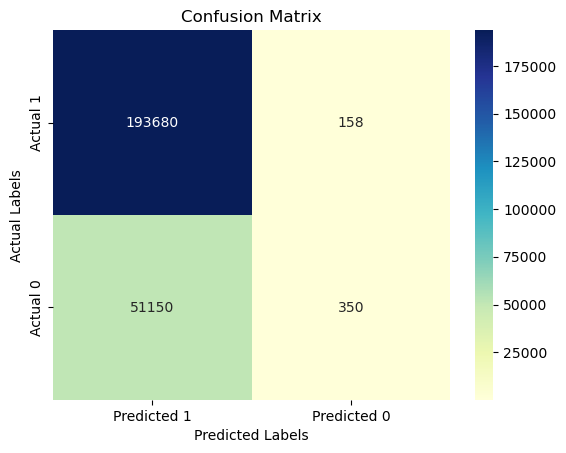

Validation AUC: 0.5030


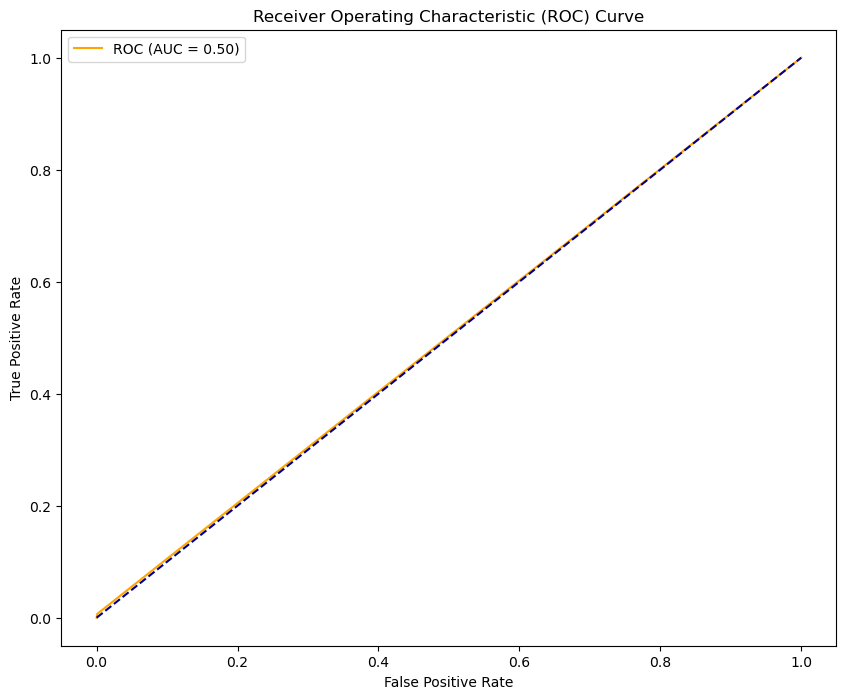

INFO:sagemaker.image_uris:Defaulting to only available Python version: py3
INFO:sagemaker.image_uris:Defaulting to only supported image scope: cpu.


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2023-11-02-15-59-19-513


2023-11-02 15:59:19 Starting - Starting the training job...
2023-11-02 15:59:38 Starting - Preparing the instances for training.........
2023-11-02 16:01:09 Downloading - Downloading input data...
2023-11-02 16:01:49 Training - Downloading the training image...
2023-11-02 16:01:54 Training - Training image download completed. Training in progress..[2023-11-02 16:02:17.136 ip-10-2-160-114.ec2.internal:7 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter eval_metric value auc to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:roo

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2023-11-02-16-04-07-684
INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2023-11-02-16-04-08-382


.....................................[2023-11-02:16:10:19:INFO] No GPUs detected (normal if no gpus installed)
[2023-11-02:16:10:19:INFO] No GPUs detected (normal if no gpus installed)
[2023-11-02:16:10:19:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      return 404 "{}";
    }
  }
}
[2023-11-02 16:10:20 +0000] [43] [INFO] Startin

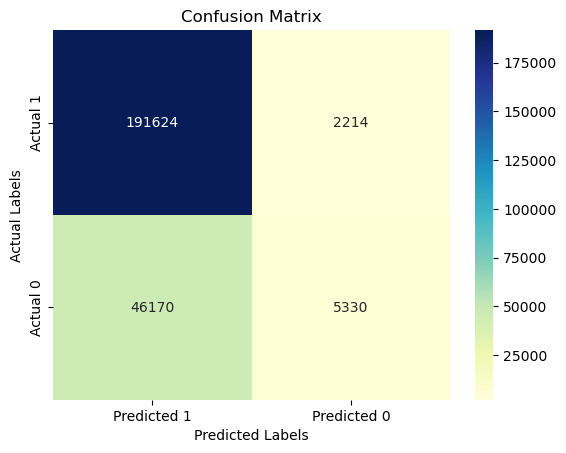

Validation AUC: 0.5460


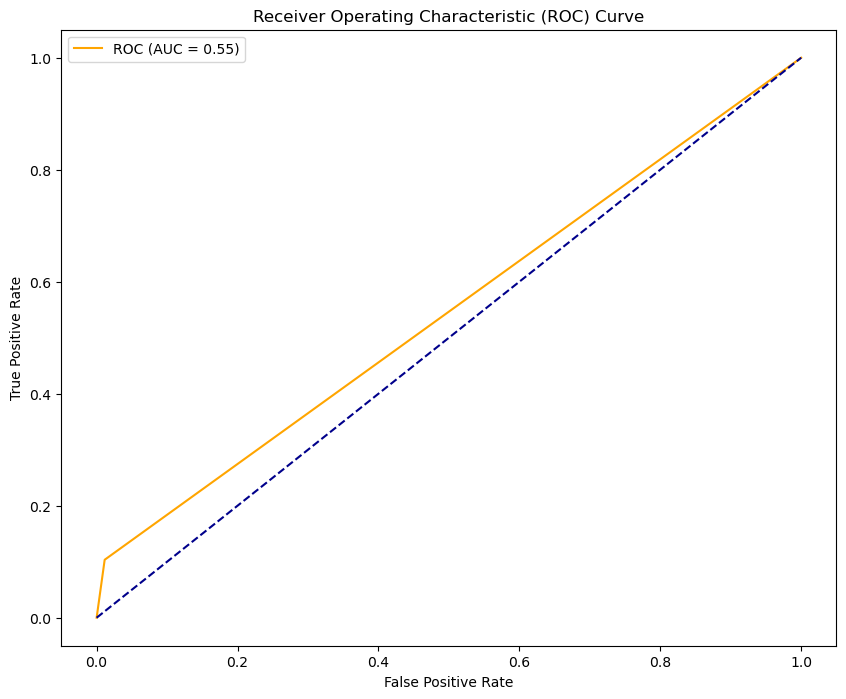

In [34]:
# Loop through the datasets, train the model, and perform batch transformations
for prefix, train, validate, test in datasets:
    upload_to_s3(prefix, train, validate, test)       # Upload data to S3
    xgb_model = train_xgb(prefix, train, validate)    # Train the XGBoost model
    transformer = batch_transform(prefix, xgb_model, test)  # Batch transform the test data
    evaluate_results(prefix, test)  # Fetch results and evaluate them